<div style="text-align: center;">

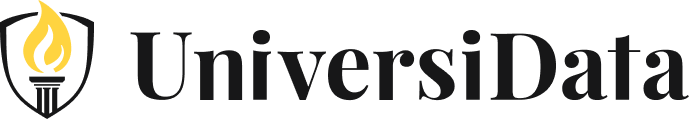

</div>

# Select group

Create a folder called `group_<name>` and place all results there:

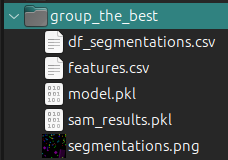

where $\texttt{features.csv}$ just contains, in one line:

```
<feature_name_1>,<feature_name_2>, ... ,<feature_name_N> 
```

The widget below will allow you to select it and run the tests:

In [1]:
import os
import glob
import ipywidgets as widgets
import pandas as pd
from IPython.display import display

folders = sorted([f for f in glob.glob("group_*") if os.path.isdir(f)])

path_results = None
df_features = None
features = None

folder_selector = widgets.Dropdown(
    options=[("Select a folder", None)] + [(f, f) for f in folders],
    description="Folder"
)

output = widgets.Output()

def on_select(change):
    global path_results, df_features, features, group
    path_results = change["new"]

    output.clear_output()

    if path_results is None:
        with output:
            print("No folder selected")
        return

    with output:
        print(f"Selected folder: {path_results}")
        print("Contents:")
        for item in os.listdir(path_results):
            print("  ", item)

        feature_file = os.path.join(path_results, "features.csv")

        if os.path.exists(feature_file):
            try:
                df_features = pd.read_csv(feature_file)
                features = list(df_features.columns)
                print("\nLoaded features.csv")
                print(" ", features)
            except Exception as e:
                print("Error loading features.csv:", e)
        else:
            print("\nNo features.csv found")

        group = os.path.basename(path_results)

folder_selector.observe(on_select, names="value")

display(folder_selector)
display(output)

Dropdown(description='Folder', options=(('Select a folder', None), ('group_0_solution', 'group_0_solution'), (…

Output()

# Custom classes

## Team 1

In [56]:
'''Team 1'''
import pandas as pd
import numpy as np

class TheOutliersPredictor:
    def __init__(
            self,
            model):
        self.model = model
    
    def predict(self, X_test: pd.DataFrame):
        X_test = self.preprocessor_f1(X_test)
        X_test = self.add_neighbor_features(X_test)
        X_test = self.add_min_distance_feature(X_test)

        features = [
            "patch_area",
            "sqrt_area",
            "diag_score",
            "area_diag",
            "cx_norm",
            "cy_norm",
            "bbox_width",
            "bbox_height",
            "bbox_ratio",
            "perimeter_bb",
            "nearest_distance",
            "image_ID",
            "patch_ID",
            "sun_factor"
        ]
        X_test = X_test[features]
        y_pred = self.model.predict(X_test)
        return y_pred


    def bbox_to_wh(self, bbox):
        ymin, xmin, ymax, xmax = bbox
        return xmax - xmin, ymax - ymin
    
    def preprocessor_f1(self, train_df:pd.DataFrame) -> pd.DataFrame:
        train_df = train_df.copy()
        
        train_df["bbox_width"]  = train_df["bbox"].apply(lambda b: self.bbox_to_wh(b)[0])
        train_df["bbox_height"] = train_df["bbox"].apply(lambda b: self.bbox_to_wh(b)[1])
        train_df["bbox_ratio"]  = train_df["bbox_width"] / (train_df["bbox_height"] + 1e-8)

        # --- coordinate GLOBALI 1500x1500 ---
        tile_rows = train_df["image_ID"] // 5
        tile_cols = train_df["image_ID"] % 5

        train_df["global_x"] = tile_cols * 300 + train_df["centroid_x"]
        train_df["global_y"] = tile_rows * 300 + train_df["centroid_y"]

        train_df["cx_norm"] = train_df["global_x"] / 1500.0
        train_df["cy_norm"] = train_df["global_y"] / 1500.0

        # distanza dalla diagonale e "score diagonale"
        train_df["dist_diag"]  = np.abs(train_df["cx_norm"] - train_df["cy_norm"])
        train_df["diag_score"] = 1.0 - train_df["dist_diag"]

        # interazione "tetto grande + vicino alla diagonale"
        train_df["area_diag"] = train_df["patch_area"] * train_df["diag_score"]

        # qualche altra feature morbida
        train_df["sqrt_area"]   = np.sqrt(train_df["patch_area"])
        train_df["perimeter_bb"] = 2*(train_df["bbox_width"] + train_df["bbox_height"])

        image_ID_sun_factor_dict = {
            0 : [0,6,12,18,24],
            1 : [5,1,11,7,17,13,23,19],
            2 : [2,10,8,16,14,22],
            3 : [15,20,21,3,4,9]
        }

        for key, val in image_ID_sun_factor_dict.items():
            train_df.loc[train_df['image_ID'].isin(val), 'sun_factor'] = key

        return train_df

    def add_neighbor_features(self, df:pd.DataFrame) -> pd.DataFrame:
        neighbors_count = pd.Series(0.0, index=df.index)
        avg_neighbor_area = pd.Series(np.nan, index=df.index)

        for image_id, group in df.groupby("image_ID"):
            idx = group.index.to_numpy()
            coords = group[["centroid_x", "centroid_y"]].to_numpy(dtype=float)
            areas = group["patch_area"].to_numpy(dtype=float)

            if len(group) <= 1:
                neighbors_count.loc[idx] = 0.0
                avg_neighbor_area.loc[idx] = np.nan
                continue

            n = len(group)
            neighbors_count.loc[idx] = float(n - 1)

            # area media degli altri patch
            total_area = areas.sum()
            avg_area = (total_area - areas) / (n - 1)
            avg_neighbor_area.loc[idx] = avg_area

        df = df.copy()  # evita SettingWithCopyWarning
        df["neighbors_count"] = neighbors_count
        df["avg_neighbor_area"] = avg_neighbor_area  # scommentato come nella logica originale

        return df
    
    def add_min_distance_feature(self, df: pd.DataFrame) -> pd.DataFrame:
        nearest_distance = pd.Series(np.inf, index=df.index, dtype=float)
        max_possible_distance = 300 * np.sqrt(2)

        for image_id, group in df.groupby("image_ID"):
            idx = group.index.to_numpy()
            coords = group[["centroid_x", "centroid_y"]].to_numpy(dtype=float)

            if len(group) <= 1:
                nearest_distance.loc[idx] = max_possible_distance
                continue

            # Matrice delle distanze euclidee
            diff = coords[:, None, :] - coords[None, :, :]
            dist_matrix = np.sqrt(np.sum(diff ** 2, axis=2))
            np.fill_diagonal(dist_matrix, np.inf)  # Esclude distanza zero (stesso punto)

            min_dists = dist_matrix.min(axis=1)
            nearest_distance.loc[idx] = min_dists

        df = df.copy()  # evita SettingWithCopyWarning
        df["nearest_distance"] = nearest_distance
        df["log_nearest_distance"] = np.log1p(df["nearest_distance"])
        df["neighbor_density"] = df["neighbors_count"] / (df["nearest_distance"] + 1e-6)

        return df
    

## Team 2

In [57]:
'''Team 2'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

class CustomModelTrainer:
    """
    Una classe per incapsulare il pre-processing, lo scaling e l'addestramento 
    di un modello di Machine Learning su un DataFrame.
    """

    def __init__(self, model):
        """
        Inizializza il Trainer.

        Args:
            target_col (str): Il nome della colonna target (variabile dipendente).
            model (object, optional): L'istanza del modello di Scikit-learn da utilizzare. 
                                      Default: LinearRegression.
            test_size (float): La porzione del dataset da usare per il test (predizione).
            random_state (int): Seed per la riproducibilità.
        """
        self.model = model
        self.scaler = StandardScaler().set_output(transform="pandas")
        self.pred = None
                                  

    def modifica_coordinate(self, id, x, y):

        if id in [0,1,2,3,4]:
          coord_x = 300*id + x
          coord_y = 300*4 + y
        elif id in [5,6,7,8,9]:
          coord_x = 300*(id-5) + x
          coord_y = 300*3 + y
        elif id in [10,11,12,13,14]:
          coord_x = 300*(id-10) + x
          coord_y = 300*2 + y
        elif id in [15,16,17,18,19]:
          coord_x = 300*(id-15) + x
          coord_y = 300 + y
        elif id in [20,21,22,23,24]:
          coord_x = 300*(id-20) + x
          coord_y = y
        else:
          print("Errore ID")
          return

        return (coord_x, coord_y)
    

    def preprocessing(self, dati:pd.DataFrame) -> (pd.DataFrame):
        dati = dati.copy()

        # spacchetto la tupla bbox
        nuove_colonne = ['bbox_x', 'bbox_y', 'bbox_h', 'bbox_w']

        # 1. Converte la Serie di tuple in un array NumPy 2D
        dati_estratti = np.stack(dati['bbox'].values)

        # 2. Assegna l'array al DataFrame
        dati[nuove_colonne] = dati_estratti

        dati["centroid_x"] = dati.apply(lambda row: self.modifica_coordinate(row["image_ID"], row["centroid_x"], row["centroid_y"])[0], axis=1)
        dati["centroid_y"] = dati.apply(lambda row: self.modifica_coordinate(row["image_ID"], row["centroid_x"], row["centroid_y"])[1], axis=1)
        dati["bbox_x"] = dati.apply(lambda row: self.modifica_coordinate(row["image_ID"], row["bbox_x"], row["bbox_y"])[0], axis=1)
        dati["bbox_y"] = dati.apply(lambda row: self.modifica_coordinate(row["image_ID"], row["bbox_x"], row["bbox_y"])[1], axis=1)
        # 4. CREAZIONE DEL COLUMNTRANSFORMER E PIPELINE
        # StandardScaler per le variabili numeriche continue

        features = ['centroid_x', 'centroid_y', 'patch_area', "image_ID", "bbox_x", "bbox_y"]
        target = 'value'

        db_modificato = dati[features] 

        return db_modificato 
                                  


    def predict(self, db:pd.DataFrame) -> np.ndarray:
        """
        Effettua la predizione sul set di test (X_test).

        Returns:
            np.ndarray: Le predizioni del modello.
        """
        dati_modificati = self.preprocessing(db)

        features = ['centroid_x', 'centroid_y', 'patch_area', "image_ID", "bbox_x", "bbox_y"]

        X_test = dati_modificati[dati_modificati.image_ID == 24][features]

        return self.model.predict(X_test)

## Team 3

In [58]:
'''Team 3'''
import ast
import numpy as np
from scipy.spatial.distance import cdist

class MyModel_3():

    def __init__(self, model):
        self.model = model
    
    def preprocess_data_for_prediction(self, df_raw):
        # Create a copy to avoid modifying the original DataFrame
        df_processed = df_raw.copy(deep=True)

        # 1. Extract Bbox Features
        def extract_bbox_features(bbox):
            
          if isinstance(bbox, str):
            bbox = ast.literal_eval(bbox)

          ymin, xmin, ymax, xmax = bbox
          bbox_height = ymax - ymin
          bbox_width = xmax - xmin
          bbox_area = bbox_height * bbox_width
          bbox_aspect_ratio = bbox_width / bbox_height if bbox_height != 0 else 0 # Avoid division by zero
          return pd.Series({
              'bbox_height': bbox_height,
              'bbox_width': bbox_width,
              'bbox_area': bbox_area,
              'bbox_aspect_ratio': bbox_aspect_ratio
          })
        
        df_processed[['bbox_height', 'bbox_width', 'bbox_area', 'bbox_aspect_ratio']] = df_processed['bbox'].apply(extract_bbox_features)
        df_processed = df_processed.drop(columns=['bbox'])
    
        # 2. Calculate Compactness Feature
        # Handle potential division by zero for bbox_area if it's 0 after extraction
        df_processed['bbox_area_safe'] = df_processed['bbox_area'].replace(0, np.finfo(float).eps)
        df_processed['compactness'] = df_processed['patch_area'] / df_processed['bbox_area_safe']
    
        # 3. Apply Log Transformations
        df_processed['log_patch_area'] = np.log1p(df_processed['patch_area'])
        df_processed['log_bbox_height'] = np.log1p(df_processed['bbox_height'])
        df_processed['log_bbox_width'] = np.log1p(df_processed['bbox_width'])
        df_processed['log_bbox_area'] = np.log1p(df_processed['bbox_area'])
    
        # 4. Create Polynomial Features
        df_processed['patch_area_squared'] = df_processed['patch_area']**2
        df_processed['bbox_area_squared'] = df_processed['bbox_area']**2
    
        # 5. Create Centroid Interaction Feature
        df_processed['centroid_xy_interaction'] = df_processed['centroid_x'] * df_processed['centroid_y']
    
        # 6. Calculate Shape Irregularity
        df_processed['shape_irregularity'] = 1 - df_processed['compactness']
    
        # 7. Calculate Bbox Perimeter and Ratio
        df_processed['bbox_perimeter'] = 2 * (df_processed['bbox_height'] + df_processed['bbox_width'])
        # Handle potential division by zero for bbox_area in bbox_perimeter_ratio
        df_processed['bbox_perimeter_ratio'] = df_processed['bbox_perimeter'] / df_processed['bbox_area_safe']
    
        # 8. Calculate Distance From Center
        center_x, center_y = 150, 150
        df_processed['distance_from_center'] = np.sqrt((df_processed['centroid_x'] - center_x)**2 + (df_processed['centroid_y'] - center_y)**2)
    
        # 9. Calculate Roundness
        # Handle potential division by zero for bbox_perimeter
        df_processed['bbox_perimeter_safe'] = df_processed['bbox_perimeter'].replace(0, np.finfo(float).eps)
        df_processed['roundness'] = 4 * np.pi * df_processed['patch_area'] / (df_processed['bbox_perimeter_safe']**2)
    
        # 10. Calculate Perimeter Compactness
        df_processed['perimeter_compactness'] = np.sqrt(df_processed['patch_area']) / df_processed['bbox_perimeter_safe']
    
        # 11. Derive Normalized Spatial Features
        image_width = 300
        image_height = 300
        df_processed['cx_norm'] = df_processed['centroid_x'] / image_width
        df_processed['cy_norm'] = df_processed['centroid_y'] / image_height
    
        # 12. Derive Area Ratios
        image_area = image_width * image_height # This was 512*512 previously, but the problem description said 300x300 example images, sticking to those, assuming train is the same.
        df_processed['area_ratio'] = df_processed['patch_area'] / image_area
        df_processed['bbox_area_ratio'] = df_processed['bbox_area'] / image_area
    
        # 13. Derive Relational Features per Image
        patch_counts = df_processed.groupby('image_ID')['patch_ID'].transform('count')
        df_processed['patch_count'] = patch_counts
        df_processed['patch_density'] = df_processed['patch_count'] / image_area
    
        mean_centroids = df_processed.groupby('image_ID')[['centroid_x', 'centroid_y']].transform('mean')
        df_processed['mean_centroid_x'] = mean_centroids['centroid_x']
        df_processed['mean_centroid_y'] = mean_centroids['centroid_y']
    
        df_processed['dist_from_mean'] = np.sqrt(
            np.power(df_processed['centroid_x'] - df_processed['mean_centroid_x'], 2) +
            np.power(df_processed['centroid_y'] - df_processed['mean_centroid_y'], 2)
        )
    
        # 14. Derive Proportional Shape Invariants
        df_processed['bbox_width_safe'] = df_processed['bbox_width'].replace(0, np.finfo(float).eps)
        df_processed['bbox_height_safe'] = df_processed['bbox_height'].replace(0, np.finfo(float).eps)
    
        df_processed['area_over_width2'] = df_processed['patch_area'] / (df_processed['bbox_width_safe']**2)
        df_processed['height_over_width'] = df_processed['bbox_height'] / df_processed['bbox_width_safe']
        df_processed['centroid_x_over_width'] = df_processed['centroid_x'] / df_processed['bbox_width_safe']
        df_processed['centroid_y_over_height'] = df_processed['centroid_y'] / df_processed['bbox_height_safe']
    
        # 1. Define image_width and image_height and calculate image_area
        image_width = 300
        image_height = 300
        image_area = image_width * image_height
    
        # 2. Calculate relative_patch_area
        df_processed['relative_patch_area'] = df_processed['patch_area'] / image_area
    
        # 3. Calculate relative_bbox_area
        df_processed['relative_bbox_area'] = df_processed['bbox_area'] / image_area
    
        # 4. Initialize new columns
        df_processed['distance_to_closest_building'] = 0
        df_processed['num_close_buildings'] = 0
    
        # 5. Set close_distance_threshold
        close_distance_threshold = 50 # pixels
    
        # 6. Iterate through each unique image_ID
        for image_id in df_processed['image_ID'].unique():
            image_df = df_processed[df_processed['image_ID'] == image_id].copy()
    
            if len(image_df) > 1:
                # Extract centroids
                centroids = image_df[['centroid_x', 'centroid_y']].values
    
                # Calculate pairwise Euclidean distances
                distances = cdist(centroids, centroids, 'euclidean')
    
                # For each building, find min distance to another building and count close buildings
                for i, (idx, row) in enumerate(image_df.iterrows()):
                    # Exclude distance to itself (diagonal is 0, so set to infinity for min calc)
                    distances_to_others = np.delete(distances[i], i)
    
                    # Find minimum distance to another building
                    min_dist = np.min(distances_to_others) if distances_to_others.size > 0 else np.nan
    
                    # Count how many other buildings are within the threshold
                    num_close = np.sum(distances_to_others < close_distance_threshold)
    
                    # Update df_train with calculated values
                    df_processed.loc[idx, 'distance_to_closest_building'] = min_dist
                    df_processed.loc[idx, 'num_close_buildings'] = num_close
    
        # Define the final features and their order as in X_final_reduced
        final_features = ['bbox_area_squared', 'centroid_xy_interaction', 'patch_count',
                          'mean_centroid_x', 'mean_centroid_y', 'centroid_y_over_height',
                          'distance_to_closest_building', 'num_close_buildings']
    
        # Select and return only the final features in the specified order
        return df_processed[final_features]

    def predict(self, df_raw):
        df = self.preprocess_data_for_prediction(df_raw)
        return np.array(self.model.predict(df.values))

## Team 4

In [59]:
import ast
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

TEST_SIZE = 0.2
RANDOM_STATE = 42


class Regression_roc_and_roll:

    def __init__(self, model=None):
        self.model = model

    def feature_creation(self, X):
        df_features = X.copy()

        def parse_bbox(x):
            if isinstance(x, (tuple, list, np.ndarray)):
                return list(x)
            if isinstance(x, str):
                return list(ast.literal_eval(x))
            raise ValueError(f"Formato bbox non riconosciuto: {x}")

        bbox_parsed = df_features["bbox"].apply(parse_bbox)
        df_features[["ymin", "xmin", "ymax", "xmax"]] = pd.DataFrame(
            bbox_parsed.tolist(), index=df_features.index
        )
        # -----------------------------------------------------
        # 2.2 Feature geometriche di base
        # -----------------------------------------------------
        df_features["bbox_width"] = df_features["xmax"] - df_features["xmin"]
        df_features["bbox_height"] = df_features["ymax"] - df_features["ymin"]
        df_features["bbox_area"] = df_features["bbox_width"] * df_features["bbox_height"]
        df_features["bbox_perimeter"] = 2 * (df_features["bbox_width"] + df_features["bbox_height"])

        # dimensioni min/max e ratio
        df_features["bbox_min_dim"] = np.minimum(df_features["bbox_width"], df_features["bbox_height"])
        df_features["bbox_max_dim"] = np.maximum(df_features["bbox_width"], df_features["bbox_height"])
        df_features["bbox_aspect_ratio"] = df_features["bbox_width"] / (df_features["bbox_height"] + 1e-6)
        df_features["bbox_dim_ratio"] = df_features["bbox_max_dim"] / (df_features["bbox_min_dim"] + 1e-6)

        # compactness / solidity / shape avanzate
        df_features["bbox_compactness"] = df_features["patch_area"] / (df_features["bbox_area"] + 1e-6)

        df_features["elongation"] = np.maximum(
            df_features["bbox_width"] / (df_features["bbox_height"] + 1e-6),
            df_features["bbox_height"] / (df_features["bbox_width"] + 1e-6)
        )

        df_features["circularity"] = (4 * np.pi * df_features["patch_area"]) / (
            df_features["bbox_perimeter"]**2 + 1e-6
        )

        df_features["irregularity"] = 1 - df_features["bbox_compactness"]
        df_features["solidity"] = df_features["patch_area"] / (df_features["bbox_area"] + 1e-6)

        # -----------------------------------------------------
        # 2.3 Trasformazioni non lineari (area / bbox)
        # -----------------------------------------------------
        df_features["log_patch_area"] = np.log1p(df_features["patch_area"])
        df_features["log_bbox_area"] = np.log1p(df_features["bbox_area"])
        df_features["sqrt_patch_area"] = np.sqrt(df_features["patch_area"])
        df_features["sqrt_bbox_area"] = np.sqrt(df_features["bbox_area"])

        # polinomiali base
        df_features["patch_area_sq"] = df_features["patch_area"] ** 2
        df_features["bbox_width_sq"] = df_features["bbox_width"] ** 2
        df_features["bbox_height_sq"] = df_features["bbox_height"] ** 2

        # -----------------------------------------------------
        # 2.4 Feature spaziali normalizzate
        # -----------------------------------------------------
        df_features["centroid_x_norm"] = (
            (df_features["centroid_x"] - df_features["centroid_x"].min()) /
            (df_features["centroid_x"].max() - df_features["centroid_x"].min() + 1e-6)
        )
        df_features["centroid_y_norm"] = (
            (df_features["centroid_y"] - df_features["centroid_y"].min()) /
            (df_features["centroid_y"].max() - df_features["centroid_y"].min() + 1e-6)
        )

        df_features["offset_x"] = df_features["centroid_x_norm"] - 0.5
        df_features["offset_y"] = df_features["centroid_y_norm"] - 0.5
        df_features["dist_center"] = np.sqrt(df_features["offset_x"]**2 + df_features["offset_y"]**2)
        df_features["angle_from_center"] = np.arctan2(df_features["offset_y"], df_features["offset_x"])

        # quadrante (0..3)
        df_features["quadrant"] = (
            (df_features["centroid_x_norm"] > 0.5).astype(int) * 2 +
            (df_features["centroid_y_norm"] > 0.5).astype(int)
        )

        # versione non lineare della distanza dal centro (kernel esponenziale)
        df_features["dist_center_exp"] = np.exp(-3.0 * df_features["dist_center"])

        # -----------------------------------------------------
        # 2.5 Aggregati per immagine (SENZA target)
        # -----------------------------------------------------
        patch_counts = df_features.groupby("image_ID").size().reset_index(name='patches_per_image')

        area_stats = df_features.groupby("image_ID").agg({
            'patch_area': ['mean', 'sum', 'std'],
            'bbox_area': ['mean', 'sum']
        }).reset_index()

        area_stats.columns = [
            'image_ID',
            'img_patch_area_mean',
            'img_patch_area_sum',
            'img_patch_area_std',
            'img_bbox_area_mean',
            'img_bbox_area_sum'
        ]

        # Funzioni gini / entropia
        def gini(arr):
            arr = np.asarray(arr, dtype=float).flatten()
            if arr.size == 0:
                return 0.0
            if np.amin(arr) < 0:
                arr -= np.amin(arr)
            arr += 1e-6
            arr = np.sort(arr)
            n = arr.size
            index = np.arange(1, n + 1)
            return (2.0 * np.sum(index * arr)) / (n * np.sum(arr)) - (n + 1) / n

        def entropy(arr):
            arr = np.asarray(arr, dtype=float).flatten()
            s = arr.sum()
            if s <= 0:
                return 0.0
            p = arr / s
            p = p[p > 0]
            return -np.sum(p * np.log(p + 1e-6))

        gini_area = df_features.groupby("image_ID")["patch_area"].apply(gini).rename("gini_patch_area")
        ent_area = df_features.groupby("image_ID")["patch_area"].apply(entropy).rename("entropy_patch_area")

        # Merge aggregati
        df_features = df_features.merge(patch_counts, on='image_ID', how='left')
        df_features = df_features.merge(area_stats, on='image_ID', how='left')
        df_features = df_features.merge(gini_area, on='image_ID', how='left')
        df_features = df_features.merge(ent_area, on='image_ID', how='left')

        # -----------------------------------------------------
        # 2.6 Feature relative all'immagine / dominance
        # -----------------------------------------------------
        df_features["rel_patch_area"] = df_features["patch_area"] / (df_features["img_patch_area_mean"] + 1e-6)
        df_features["rel_bbox_area"] = df_features["bbox_area"] / (df_features["img_bbox_area_mean"] + 1e-6)
        df_features["area_rank_in_image"] = df_features.groupby("image_ID")["patch_area"].rank(pct=True)
        df_features["density_contribution"] = df_features["patch_area"] / (df_features["img_patch_area_sum"] + 1e-6)

        # rapporto rispetto al patch più grande nell'immagine
        df_features["rel_to_max_patch"] = df_features["patch_area"] / (
            df_features.groupby("image_ID")["patch_area"].transform("max") + 1e-6
        )

        # dominance rispetto ai top-3 patch dell'immagine
        def topk_sum(s, k=3):
            v = np.sort(s.values)
            if len(v) == 0:
                return 0.0
            return v[-k:].sum() if len(v) >= k else v.sum()

        top3_sum = df_features.groupby("image_ID")["patch_area"].transform(lambda s: topk_sum(s, k=3))
        df_features["dom_top3"] = df_features["patch_area"] / (top3_sum + 1e-6)

        # rank distanza dal centro all'interno dell'immagine
        df_features["dist_rank"] = df_features.groupby("image_ID")["dist_center"].rank(pct=True)

        # distanza relativa rispetto alla media per immagine
        df_features["dist_center_rel"] = df_features["dist_center"] / (
            df_features.groupby("image_ID")["dist_center"].transform("mean") + 1e-6
        )

        # -----------------------------------------------------
        # 2.7 Interazioni ibride (shape + contesto)
        # -----------------------------------------------------
        df_features["area_x_compactness"] = df_features["patch_area"] * df_features["bbox_compactness"]
        df_features["area_x_aspect"] = df_features["patch_area"] * df_features["bbox_aspect_ratio"]
        df_features["width_x_height"] = df_features["bbox_width"] * df_features["bbox_height"]

        df_features["area_x_perimeter"] = df_features["patch_area"] * df_features["bbox_perimeter"]
        df_features["area_x_maxdim"] = df_features["patch_area"] * df_features["bbox_max_dim"]
        df_features["area_x_relpatch"] = df_features["patch_area"] * df_features["rel_patch_area"]

        df_features["aspect_sq"] = df_features["bbox_aspect_ratio"] ** 2
        df_features["compactness_sq"] = df_features["bbox_compactness"] ** 2

        df_features["centroid_interaction"] = df_features["centroid_x_norm"] * df_features["centroid_y_norm"]

        # posizionamento del centroide rispetto al bbox
        df_features["centroid_bbox_x"] = (df_features["centroid_x"] - df_features["xmin"]) / (df_features["bbox_width"] + 1e-6)
        df_features["centroid_bbox_y"] = (df_features["centroid_y"] - df_features["ymin"]) / (df_features["bbox_height"] + 1e-6)

        # punteggi "strutturali"
        df_features["center_influence"] = df_features["patch_area"] / (1.0 + df_features["dist_center"])
        df_features["struct_score"] = (
            df_features["patch_area"] * df_features["elongation"] * (1.0 - df_features["dist_rank"])
        )
        df_features["prominence"] = (
            df_features["rel_patch_area"] * (1.0 - df_features["dist_rank"]) * df_features["rel_to_max_patch"]
        )

        df_features.replace([np.inf, -np.inf], np.nan, inplace=True)

        numeric_cols = df_features.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_features[col].isna().any():
                median_val = df_features[col].median()
                df_features[col].fillna(median_val, inplace=True)

        df_features = df_features[['image_ID', 'patch_ID',
            'bbox_area',
            'bbox_dim_ratio',
            'elongation',
            'sqrt_bbox_area',
            'patches_per_image',
            'img_patch_area_mean',
            'img_patch_area_sum',
            'img_patch_area_std',
            'img_bbox_area_mean',
            'img_bbox_area_sum',
            'gini_patch_area',
            'entropy_patch_area',
            'density_contribution',
            'area_x_perimeter',
            'centroid_bbox_x']]
        return df_features

    def fit(self, X, y):
        df_features = self.feature_creation(X)
        X_processed = df_features.drop(columns=['image_ID', 'patch_ID'])

        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
        )

        best_params = {
            'learning_rate': 0.105,
            'max_depth': 3,
            'min_samples_leaf': 4,
            'min_samples_split': 20,
            'n_estimators': 850,
            'subsample': 1.0
        }

        best_gb = GradientBoostingRegressor(
            **best_params,
            random_state=RANDOM_STATE
        )

        # Training finale
        best_gb.fit(X_train, y_train)
        y_pred_test = best_gb.predict(X_test)
        self.model = best_gb
        return y_pred_test

    def predict(self, X):
        df_features = self.feature_creation(X)
        return self.model.predict(df_features)

## Team 5

In [60]:
'''Team 5'''
import scipy.spatial as spatial
import numpy as np 
        
class MyModel_5():
    
    def __init__(self, model):
        self.model = model
    
    def preprocessing(self, df):
        df = df.copy()

        df["bbox"] = df["bbox"].astype(str)
        
        # unboxing tuple bounding boxes 
        df[['bbox1',
                  'bbox2',
                  'bbox3',
                  'bbox4']] = df.bbox.astype(str).str.replace(
                                                        '(',''
                                                        ).str.replace(
                                                                      ')',''
                                                                      ).str.replace(
                                                                                    ' ',''
                                                                                    ).str.split(',',
                                                                                                expand = True)
        df_c = df.copy()
        df_c.drop('bbox',
                        axis = 1,
                        inplace = True)
        df_c.rename(columns={'bbox1':'bbox_y_min',
                                   'bbox2':'bbox_x_min',
                                   'bbox3':'bbox_y_max',
                                   'bbox4':'bbox_x_max'},
                          inplace=True)

        df_c['bbox_y_min'] = df_c['bbox_y_min'].astype(float)
        df_c['bbox_x_min'] = df_c['bbox_x_min'].astype(float)
        df_c['bbox_y_max'] = df_c['bbox_y_max'].astype(float)
        df_c['bbox_x_max'] = df_c['bbox_x_max'].astype(float)

        df_c['bbox_y_min']=(df_c.image_ID//5)*300 + df_c.bbox_y_min
        df_c['bbox_x_min']=(df_c.image_ID%5)*300 + df_c.bbox_x_min
        df_c['bbox_y_max']=(df_c.image_ID//5)*300 + df_c.bbox_y_max
        df_c['bbox_x_max']=(df_c.image_ID%5)*300 + df_c.bbox_x_max
        
        # calcolo centroidi reali (diverso da centroide se bbox a cavallo tra più porzioni di immagine)
        df_c['centroid_x_real']= (df_c.image_ID%5)*300 + df_c.centroid_x
        df_c['centroid_y_real'] = (df_c.image_ID//5)*300 + df_c.centroid_y    

        # Features Engineering
        # calcolo frequency e distanza dalla diagonale
        points = np.array([(x, y) for x,y in zip(df_c.centroid_x_real,df_c.centroid_y_real)])
        tree = spatial.KDTree(np.array(points))
        radius = 20 #distanza per considerare vicini due centroidi in pixel

        neighbors = tree.query_ball_tree(tree, radius)

        #numero di centroidi vicini 
        frequency = np.array(list(map(len, neighbors)))

        norm_frequency = frequency/max(frequency)
        norm_frequency


        df_c['norm_frequency'] = norm_frequency

        df_c['distanza_diagonale'] = abs(
                                                df_c['centroid_x_real'] - df_c['centroid_y_real']
                                                )* np.sin(np.pi/4)
        
        X = df_c[[

                        'patch_area',
                        'bbox_y_min',
                        'bbox_x_min',
                        'centroid_x_real',
                        'centroid_y_real',
                        'norm_frequency',
                        'distanza_diagonale'
                        ]]
        return X
                
    # def predict(self, df):
    #     X = self.preprocessing(df)
    #     return self.model.predict(X)
    def predict(self, df):
        X = self.preprocessing(df)
        for est in self.model.estimators_:
            est.monotonic_cst = None
        return self.model.predict(X)


In [61]:
'''Here go any extra classes the participants included in their model, e.g.:''';

from sklearn.base import BaseEstimator, TransformerMixin

class GridDecomposer(BaseEstimator, TransformerMixin):
    def __init__(self, H=5, W=5):
        self.H = H
        self.W = W

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ids = X["image_ID"].to_numpy()

        row = ids // self.W     # vertical index
        col = ids % self.W      # horizontal index

        X_rest = X.drop(columns=["image_ID"]).to_numpy()
        return np.column_stack([row, col, X_rest])

# Setup

In [62]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set seaborn style
sns.set_theme(style="darkgrid")  # Options: "white", "dark", "whitegrid", "darkgrid", "ticks"

# Global settings for Matplotlib
plt.rcParams.update({
    "figure.figsize": (8, 4),   # Default figure size (width, height)
    "axes.titlesize": 14,       # Title font size
    "axes.labelsize": 12,       # Label font size
    "xtick.labelsize": 10,      # X-axis tick font size
    "ytick.labelsize": 10,      # Y-axis tick font size
    "legend.fontsize": 10,      # Legend font size
    "font.size": 10,            # General font size
    "figure.autolayout": True,  # Auto-layout for better spacing
    "axes.grid": True,          # Show grid
    "grid.alpha": 0.3,          # Grid transparency
    "lines.linewidth": 2,       # Default line width
    "lines.markersize": 6,      # Default marker size
    "figure.dpi": 100,          # Resolution of figures
    "savefig.dpi": 300,         # Resolution for saved figures
    "axes.spines.top": False,   # Remove top spine
    "axes.spines.right": False, # Remove right spine
    "text.color": "gray",   # Set all text color
    "axes.labelcolor": "gray",  # Set axis labels color
    "xtick.color": "gray",  # Set x-axis tick labels color
    "ytick.color": "gray",  # Set y-axis tick labels color
    "legend.edgecolor": "gray",  # Set legend edge color
    "legend.labelcolor": "gray"  # Set legend text color    
})

# Support functions

## Convert to mask

In [63]:
from skimage.transform import resize
import numpy as np

def convert_to_mask(Xhat_test_segmentation) -> np.ndarray:
    """
    Convert RGBA or RGB segmentation image to a binary numpy mask scaled 0 to 255,
    using luminance conversion then resizing to 300x300.
    """
    rgb = Xhat_test_segmentation[..., :3]
    gray = 0.299 * rgb[..., 0] + 0.587 * rgb[..., 1] + 0.114 * rgb[..., 2]
    resized = resize(gray, (300, 300), anti_aliasing=False)
    Xhat_test_msk = np.where(resized > 0., 255, 0).astype(np.uint8)
    return Xhat_test_msk

## Metrics

In [64]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def iou_score(a, b):
    """
    Intersection over Union (Jaccard Index)
    """
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-8)

def dice_score(mask_a: np.ndarray, mask_b: np.ndarray) -> float:
    """
    Dice similarity coefficient between two boolean masks.
    """
    a = mask_a.astype(bool)
    b = mask_b.astype(bool)
    inter = np.logical_and(a, b).sum()
    return (2 * inter) / (a.sum() + b.sum() + 1e-8)

def hausdorff_distance(mask_a: np.ndarray, mask_b: np.ndarray) -> float:
    """
    Symmetric Hausdorff distance (95th percentile often preferred).
    """
    pts_a = np.column_stack(np.where(mask_a > 0))
    pts_b = np.column_stack(np.where(mask_b > 0))

    if len(pts_a) == 0 or len(pts_b) == 0:
        return np.inf

    h_ab = directed_hausdorff(pts_a, pts_b)[0]
    h_ba = directed_hausdorff(pts_b, pts_a)[0]
    return max(h_ab, h_ba)

def hausdorff_95(mask_a: np.ndarray, mask_b: np.ndarray) -> float:
    """
    95th percentile Hausdorff distance (HD95).
    """
    from scipy.spatial.distance import cdist
    pts_a = np.column_stack(np.where(mask_a > 0))
    pts_b = np.column_stack(np.where(mask_b > 0))

    if len(pts_a) == 0 or len(pts_b) == 0:
        return np.inf

    dists = np.concatenate([
        np.min(cdist(pts_a, pts_b), axis=1),
        np.min(cdist(pts_b, pts_a), axis=1),
    ])

    return np.percentile(dists, 95)

def evaluate_metrics(mask_a, mask_b):
    '''Evaluate all the metrics and produce a result dataframe.'''
    iou    = iou_score(mask_a, mask_b)
    dice   = dice_score(mask_a, mask_b)
    haus_d = hausdorff_distance(mask_a, mask_b)
    haus_95 = hausdorff_95(mask_a, mask_b)
    
    df_metrics = pd.DataFrame([dict(iou=round(iou,2), dice=round(dice,2), hausdorff_distance=round(haus_d,2), hausdorff_95=round(haus_95,2))])

    return df_metrics

## Match predictions and GT

In [65]:
''' _You can use this function to check how many patches were correctly identified in each image_''';
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def match_pred_gt(
    df_pred: pd.DataFrame,
    df_gt: pd.DataFrame,
    iou_thresh: float = 0.5,
    show_matches=True,
    plot_bboxes=False,
):
    """
    Match predicted patches to ground-truth patches using an IoU threshold.

    ----------------------------------------------------------------------
    REQUIRED DATAFRAME FORMAT
    ----------------------------------------------------------------------
    Both df_pred and df_gt must follow the same column structure:

        image_ID      int
        patch_ID      int
        centroid_x    float
        centroid_y    float
        patch_area    float
        bbox          tuple (x1, y1, x2, y2)
        value         float

    Example row format:
        image_ID  patch_ID  centroid_x  centroid_y  patch_area        bbox                    value
        0         1         269.33      146.47      30.0        (143, 265, 151, 275)        22.93
        0         2         217.95      143.60      43.0        (139, 214, 149, 223)        24.71
        0         3         298.13      126.60      15.0        (124, 296, 131, 300)        26.18
        ...
        24        66        254.12      248.19     5642.0       (193, 219, 300, 290)        43.88

    Each row represents a single segmented patch inside an image. The function
    assumes:
    - bbox is a tuple of four integers (x1, y1, x2, y2)
    - coordinates are pixel coordinates within the image
    - image_ID identifies which image the patch belongs to

    ----------------------------------------------------------------------
    FUNCTION DESCRIPTION
    ----------------------------------------------------------------------
    For each ground-truth (GT) patch, the function identifies at most one
    predicted patch (from df_pred) whose bounding box overlaps the GT
    bounding box with IoU >= iou_thresh. Among all candidates, the one
    with the highest IoU is selected.

    The function returns two dataframes:

    1. df_matched:
          - One row per GT patch.
          - Ground truth columns are now prefixed with gt_.
          - Predicted columns are included with their original names
            (NO pred_ prefix anymore).
          - If no prediction matches a GT patch, predicted fields are NaN.

    2. df_pred_matched:
          - Contains only the predicted rows that were successfully matched
            to at least one GT patch.
          - Duplicate predictions (if hypothetically matched multiple times)
            are removed.

    Parameters
    ----------
    df_pred : pd.DataFrame
        Predicted patches following the required row structure above.

    df_gt : pd.DataFrame
        Ground-truth patches following the same row structure.

    iou_thresh : float, optional (default = 0.5)
        Minimum IoU required to consider a prediction a valid match.

    show_matches : bool, optional (default = True)
      Print percentage of matches per image

    plot_bboxes : bool, optional (default = False)
      Plot matches on test image (image_ID == 24) using bboxes.
      
    Returns
    -------
    df_matched : pd.DataFrame
        One row per GT patch with gt_* fields and predicted fields.

    df_pred_matched : pd.DataFrame
        All predicted rows that matched at least one GT patch, deduplicated.

    Notes
    -----
    - Matching is per image_ID.
    - Each GT patch receives at most one matched prediction.
    - IoU is computed on axis-aligned bounding boxes.
    """;

    keep_pred_cols = ["patch_ID", "centroid_x", "centroid_y", "bbox", "value", "patch_area"]

    def iou(a, b):
        
        ax1, ay1, ax2, ay2 = a
        bx1, by1, bx2, by2 = b

        ix1, iy1 = max(ax1, bx1), max(ay1, by1)
        ix2, iy2 = min(ax2, bx2), min(ay2, by2)

        iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
        inter = iw * ih
        if inter == 0:
            return 0

        area_a = (ax2 - ax1)*(ay2 - ay1)
        area_b = (bx2 - bx1)*(by2 - by1)
        return inter / (area_a + area_b - inter)

    rows = []
    summary_rows = []
    valid_pred_rows = []

    common_ids = set(df_gt.image_ID.unique()).intersection(df_pred.image_ID.unique())

    for img_id in common_ids:
        gt_img   = df_gt[df_gt.image_ID == img_id]
        pred_img = df_pred[df_pred.image_ID == img_id]

        n_gt   = len(gt_img)
        n_pred = len(pred_img)

        matched_count = 0
        for _, gt_row in gt_img.iterrows():
            gt_box = gt_row["bbox"]
            best = None
            best_score = 0

            for _, pred_row in pred_img.iterrows():                
                score = iou(gt_box, pred_row["bbox"])
                if score >= iou_thresh and score > best_score:
                    best = pred_row
                    best_score = score

            if best is not None:
                matched_count += 1
                valid_pred_rows.append(best)

            # --------------------------
            # BUILD MERGED ROW
            # --------------------------
            merged = {}

            # GT columns → prepend gt_
            for col in df_gt.columns:
                merged[f"gt_{col}"] = gt_row[col]

            # Prediction columns → keep original names
            for col in keep_pred_cols:
                merged[col] = None if best is None else best[col]

            rows.append(merged)

        summary_rows.append({
            "image_ID": img_id,
            "n_gt": n_gt,  # P
            "n_pred": n_pred,  # TP + FP
            "n_matched": matched_count,  # TP
            "pct_matched": round(matched_count / n_gt * 100, 1),
            "Recall": round(matched_count / n_gt, 3),  # TP / P
            "Precision": round(matched_count / n_pred, 3)  # TP / (TP + FP) 
        })

    df_summary = pd.DataFrame(summary_rows).sort_values("image_ID")
    
    if show_matches:
        display(df_summary)

    df_matched = pd.DataFrame(rows).reset_index(drop=True)
    df_pred_matched = pd.DataFrame(valid_pred_rows).drop_duplicates().reset_index(drop=True)

    # Undo gt_ prefix for 'image_ID' only (keep others as gt_*)
    df_matched = df_matched.rename(columns={"gt_image_ID": "image_ID"})

    # ======================================
    # Bboxes
    # ======================================
    if img_id == 24 and plot_bboxes == True:

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
        # === Left: all boxes ===
        ax = axes[0]
        
        for _, row in gt_img.iterrows():
            x1, y1, x2, y2 = row["bbox"]
            ax.add_patch(patches.Rectangle(
                (y1, x1), (y2 - y1), (x2 - x1),
                linewidth=1, edgecolor="C0", facecolor="none"
            ))
        
        for _, row in pred_img.iterrows():
            x1, y1, x2, y2 = row["bbox"]
            ax.add_patch(patches.Rectangle(
                (y1, x1), (y2 - y1), (x2 - x1),
                linewidth=1, edgecolor="C3", facecolor="none"
            ))
        
            cx = (y1 + y2) / 2
            cy = (x1 + x2) / 2
        
            ax.text(cx, cy, str(row["patch_ID"]), color="C3",
                    ha="center", va="center", fontsize=8)
        
        ax.set_aspect("equal")
        ax.set_title(f"All bboxes")


        # === Middle: all best GT–pred pairs (any IoU) ===
        ax = axes[1]
    
        pairs = []  # (gt_box, pred_box, iou_val)
        for _, gt_row in gt_img.iterrows():
            gt_box = gt_row["bbox"]
            best = None
            best_score = 0.0
            for _, pred_row in pred_img.iterrows():
                score = iou(gt_box, pred_row["bbox"])
                if score > best_score:
                    best_score = score
                    best = pred_row
            if best is not None:
                pairs.append((gt_box, best["bbox"], best_score))
    
        for gt_box, pred_box, score in pairs:
            gx1, gy1, gx2, gy2 = gt_box
            px1, py1, px2, py2 = pred_box
    
            # GT box
            ax.add_patch(patches.Rectangle(
                (gy1, gx1), (gy2 - gy1), (gx2 - gx1),
                linewidth=1, edgecolor="C0", facecolor="none"
            ))
            # Pred box
            ax.add_patch(patches.Rectangle(
                (py1, px1), (py2 - py1), (px2 - px1),
                linewidth=1, edgecolor="C1", facecolor="none"
            ))
            # IoU label (at GT center)
            cx = 0.5 * (gy1 + gy2)
            cy = 0.5 * (gx1 + gx2)
            ax.text(cx, cy, f"{score:.2f}", ha="center", va="center", fontsize=8)
    
        ax.set_title(f"All pairs (best IoU)")
    
    
        # === Right: matched boxes only (IoU >= threshold) ===
        matched_img = df_matched[df_matched["image_ID"] == img_id]
        matched_img = matched_img[~matched_img["patch_ID"].isna()]
    
        ax = axes[2]
    
        for gt_box, pred_box in zip(matched_img["gt_bbox"], matched_img["bbox"]):
            gx1, gy1, gx2, gy2 = gt_box
            px1, py1, px2, py2 = pred_box
            score = iou(gt_box, pred_box)
    
            # GT box
            ax.add_patch(patches.Rectangle(
                (gy1, gx1), (gy2 - gy1), (gx2 - gx1),
                linewidth=1, edgecolor="C0", facecolor="none"
            ))
            # Pred box
            ax.add_patch(patches.Rectangle(
                (py1, px1), (py2 - py1), (px2 - px1),
                linewidth=1, edgecolor="C2", facecolor="none"
            ))

            ax.set_title(f"Matches (IoU ≥ {iou_thresh})")

        for ax in axes:
            ax.set_xlim(0, 300)
            ax.set_ylim(0, 300)
            # ax.axis("off")
            ax.invert_yaxis()
            ax.set_aspect("equal")
    
        plt.tight_layout()
        plt.savefig(path_results+'/assess_matches.png', dpi=300)
        plt.show()

    return df_matched, df_pred_matched, df_summary

# Load

## Load provided data and ground truth

In [66]:
# === Load the bundle ===
with open("../data/bundle_assessment.pkl", "rb") as f:
    bundle_assessment = pickle.load(f)

# Test set
X_test_area = bundle_assessment["X_test_area"]
X_test_msk  = bundle_assessment["X_test_msk"]
X_test_map  = bundle_assessment["X_test_map"]
df_test      = bundle_assessment["df_test"]

df_test["bbox"] = df_test["bbox"].apply(
    lambda x: tuple(int(i) for i in str(x).replace("(", "").replace(")", "").split(","))
)  # force column to be read as tuple

display(df_test.head(3))

,image_ID,patch_ID,centroid_x,centroid_y,patch_area,bbox,value
1364,24,1,298.583333,96.416667,12.0,"(93, 298, 100, 300)",22.128243
1365,24,2,120.000000,62.000000,35.0,"(59, 118, 66, 123)",25.825889
1366,24,3,32.236842,7.078947,38.0,"(3, 29, 12, 37)",26.250156


## Load results

In [67]:
import ast

# === Load segmentations mask image ===
import matplotlib.image as mpimg

Xhat_test_segmentation = mpimg.imread(os.path.join(path_results, "segmentations.png"))

Xhat_test_msk = convert_to_mask(Xhat_test_segmentation)

# === Load the segmentations dataset ===
csv_path = os.path.join(path_results, "df_segmentations.csv")
if os.path.exists(csv_path):
    df_segmentations = pd.read_csv(csv_path, converters={
        "bbox": lambda x: ast.literal_eval(x)  # force column to be read as tuple
    })

# === Apply exceptions ===
if group == 'group_1':
    # They changed image_ID to 25
    df_segmentations.loc[df_segmentations['image_ID'] == 25, 'image_ID'] = 24

if group == 'group_2':
    # They used (x,y,Dx,Dy) as bbox
    df_segmentations["bbox"] = df_segmentations["bbox"].apply(lambda b: (b[1], b[0], b[1]+b[3], b[0]+b[2]))

if group == 'group_3':
    # They used (y,x,y',x') as bbox
    df_segmentations["bbox"] = df_segmentations["bbox"].apply(lambda b: (b[1], b[0], b[3], b[2]))

if group == 'group_4':
    # They used (x',y',x,y) as bbox
    df_segmentations["bbox"] = df_segmentations["bbox"].apply(lambda b: (b[2], b[3], b[0], b[1]))

# Remove column "Unnamed: 0" if present
df_segmentations = df_segmentations.drop(columns=["Unnamed: 0"], errors="ignore")

display(df_segmentations.head(3))
'''Check there is no extra index column (file saved incorrectly), else remove it''';

# === Load the model ===
import joblib

model = joblib.load(os.path.join(path_results, "model.pkl"))

# === Apply exceptions ===
if group == 'group_3':
    # For team 3, model == XGBoost: it must be loaded into the class
    model = MyModel_3(model)

,image_ID,patch_ID,centroid_x,centroid_y,patch_area,bbox,value
0,24,0,6.266667,245.644444,135,"(237, 0, 252, 15)",0.0
1,24,1,39.726415,270.669811,212,"(259, 31, 281, 49)",0.0
2,24,2,291.662885,20.910859,617,"(0, 282, 46, 299)",0.0


# Check 1: Predicted $vs$ ground truth segmentation images

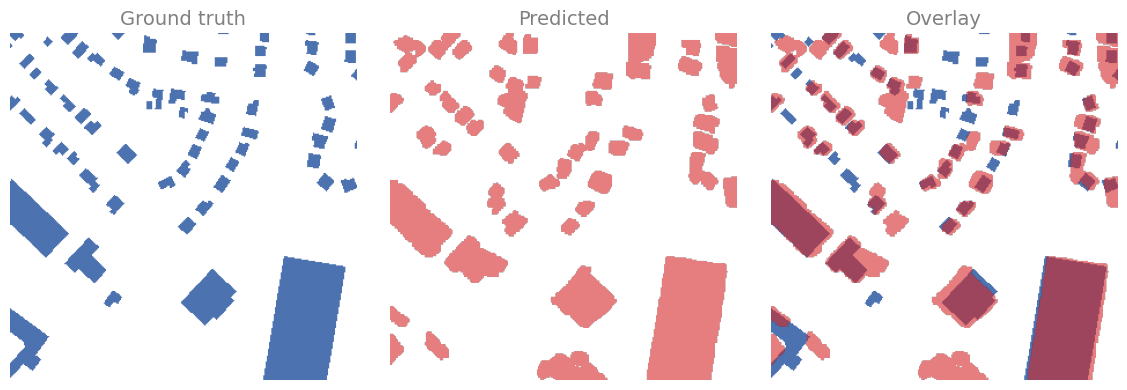

In [68]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap

cmap_b = LinearSegmentedColormap.from_list("", ["white", "C0"])
cmap_r = ListedColormap([
    (0.83921569, 0.15294118, 0.15686275, 1.0),  # red for 1
    (0, 0, 0, 0)                                # fully transparent for 0
][::-1])  # reverse so 0 maps to transparent, 1 to red

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('Ground truth')
plt.imshow((X_test_msk == 255).astype(int), cmap=cmap_b, vmin=0, vmax=1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title('Predicted')
plt.imshow((Xhat_test_msk == 255).astype(int), cmap=cmap_r, vmin=0, vmax=1, alpha=0.6)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow((X_test_msk == 255).astype(int), cmap=cmap_b, vmin=0, vmax=1)
plt.imshow((Xhat_test_msk == 255).astype(int), cmap=cmap_r, vmin=0, vmax=1, alpha=0.6)
plt.axis("off")

plt.savefig(path_results+'/assess_overlay.png', dpi=300)
plt.show()

## Metrics

In [69]:
# Compute metrics
X_test_binary = X_test_msk/255.0
Xhat_test_binary = Xhat_test_msk/255.0

df_metrics = evaluate_metrics(X_test_binary, Xhat_test_binary)

display(df_metrics)

,iou,dice,hausdorff_distance,hausdorff_95
0,0.51,0.67,60.44,16.03


# Check 2: Number of matched buildings

,image_ID,n_gt,n_pred,n_matched,pct_matched,Recall,Precision
0,24,66,49,26,39.4,0.394,0.531


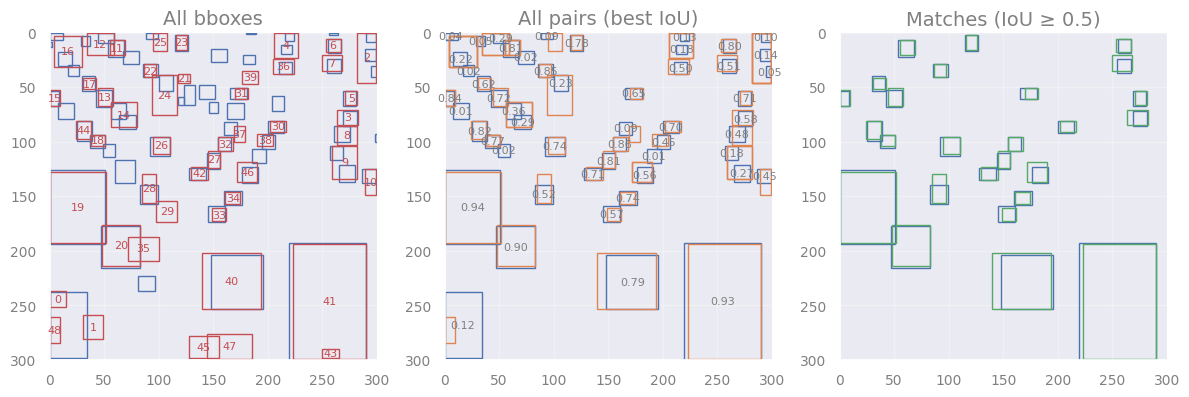

=== Buildings | Precision: 0.531 ===


In [70]:
_, _, df_summary = match_pred_gt(df_segmentations, df_test, show_matches=True, plot_bboxes=True)

print('=== Buildings | Precision: %.3f ===' % df_summary['Precision'].values[0])

# Check 3: Score on model predictions

The assessment works in 2 steps:
1. First, we only keep the entries in the predicted database which correspond to **real** buildings
2. Then, we apply the model to those entries and **calculate the MSE**

In [71]:
# Percentage matched
df_test_segmentations, df_segmentations_test, _ = match_pred_gt(df_segmentations, df_test, show_matches=True)

# Dataset of test patches actually found via SAM
df_test_found = df_test_segmentations.dropna()
display(df_test_found)
print('Number of matched patches:', len(df_test_found))  # extra check

# === Apply Exceptions ===

df_test_for_inference = df_test_found.copy(deep=True)

# Reverting to their bboxes, so their models can work as they inetended
if group == 'group_2':
    df_test_for_inference.loc[:, "bbox"] = df_test_for_inference["bbox"].apply(
        lambda b: (b[1], b[0], b[3]-b[1], b[2]-b[0])
    )

if group == 'group_3':
    df_test_for_inference.loc[:, "bbox"] = df_test_for_inference["bbox"].apply(
        lambda b: (b[1], b[0], b[3], b[2])
    )

if group == 'group_4':
    df_test_for_inference["bbox"] = df_test_for_inference["bbox"].apply(
        lambda b: (b[2], b[3], b[0], b[1])
    )    

,image_ID,n_gt,n_pred,n_matched,pct_matched,Recall,Precision
0,24,66,49,26,39.4,0.394,0.531


,image_ID,gt_patch_ID,gt_centroid_x,gt_centroid_y,gt_patch_area,gt_bbox,gt_value,patch_ID,centroid_x,centroid_y,bbox,value,patch_area
9,24,10,43.449438,99.977528,89.0,"(94, 37, 106, 51)",28.192095,18.0,45.092784,99.597938,"(94, 38, 104, 51)",0.0,97.0
12,24,13,34.681818,46.590909,88.0,"(40, 30, 54, 42)",29.132678,17.0,37.047059,47.411765,"(42, 31, 52, 43)",0.0,85.0
13,24,14,135.126214,129.262136,103.0,"(124, 128, 135, 143)",29.275678,42.0,137.120968,129.443548,"(123, 130, 135, 145)",0.0,124.0
15,24,16,49.385417,60.656250,96.0,"(53, 43, 68, 57)",29.383640,13.0,50.552239,59.798507,"(51, 44, 67, 58)",0.0,134.0
16,24,17,2.878788,59.227273,66.0,"(54, 0, 67, 9)",29.502404,15.0,3.686869,58.575758,"(53, 0, 67, 10)",0.0,99.0
18,24,19,90.255319,147.765957,141.0,"(140, 83, 157, 99)",29.568044,28.0,91.580645,142.640553,"(130, 85, 156, 98)",0.0,217.0
20,24,21,152.713178,166.038760,129.0,"(159, 145, 174, 161)",29.612884,33.0,155.238532,166.908257,"(161, 149, 173, 162)",0.0,109.0
22,24,23,31.448000,89.080000,125.0,"(81, 25, 99, 39)",29.639626,44.0,31.394286,89.194286,"(81, 24, 98, 38)",0.0,175.0
23,24,24,167.439655,150.241379,116.0,"(145, 160, 158, 176)",29.714239,34.0,168.137931,150.836207,"(146, 161, 157, 175)",0.0,116.0
25,24,26,150.076923,117.096154,104.0,"(110, 144, 125, 156)",29.755266,27.0,150.267123,116.554795,"(109, 145, 124, 156)",0.0,146.0


Number of matched patches: 26


,image_ID,patch_ID,centroid_x,centroid_y,patch_area,bbox
9,24,18.0,45.092784,99.597938,97.0,"(94, 38, 104, 51)"
12,24,17.0,37.047059,47.411765,85.0,"(42, 31, 52, 43)"
13,24,42.0,137.120968,129.443548,124.0,"(123, 130, 135, 145)"


Test set performance:
✅ MSE: 5.370
✅ R² : 0.529


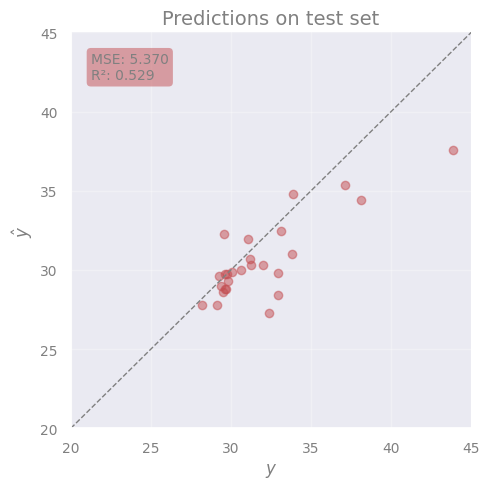

In [72]:
from sklearn.metrics import mean_squared_error, r2_score

# ================================
# Evaluate best model on test set
# ================================

X_test = df_test_for_inference[features]
display(X_test.head(3))

y_test = df_test_found["gt_value"]  # <-- ground truth value

# Predict with best estimator
yhat_test = model.predict(X_test)

# Report performance
mse_test = mean_squared_error(y_test, yhat_test)
r2_test = r2_score(y_test, yhat_test)

print("Test set performance:")
print(f"✅ MSE: {mse_test:.3f}")
print(f"✅ R² : {r2_test:.3f}")

# ================================
# Plot
# ================================

fig = plt.figure(figsize=(5,5))
plt.scatter(y_test, yhat_test, c='C3', alpha=0.5)

plt.xlim(20, 45)
plt.ylim(20, 45)
xmin, xmax = plt.xlim()

plt.plot([xmin, xmax], [xmin, xmax], ls='--', lw=1, c='grey')

plt.title("Predictions on test set")
plt.xlabel(r"$y$")
plt.ylabel(r"$\hat{y}$")

plt.text(
    0.05, 0.95,
    f"MSE: {mse_test:.3f}\nR²: {r2_test:.3f}",
    transform=plt.gca().transAxes,
    va="top", ha="left",
    bbox=dict(boxstyle="round", fc="C3", ec="none", alpha=0.5)
)

plt.savefig(path_results+'/assess_MSE.png', dpi=300)
plt.show()

In [73]:
#EOF

In [37]:
#EOF

In [81]:
#EOF

In [ ]:
#EOF